  This notebook shows an example of neural networks applied to time series classification using Tensorflow. The task here is to classify 6 different types of activities (walking, walking upstairs, walking downstairs, sitting, standing, laying) based on x, y and z accelerometer signals. In this notebook we use the raw x axis signal to feed a 2-layer Neural Network with softmax activation. We also implement L2 regularization but we set the regularization coefficient to 0.0 here. 

## Imports

In [1]:
import os
import numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report, f1_score
from sklearn import preprocessing
import matplotlib.pylab as plt
import plot_confusion_matrix as pcm
%matplotlib

Using matplotlib backend: MacOSX


## Loading data

We load the raw accelerometer signals of x axis. Each sample of the data set is a 2.56s window of an activity being performed recorded at a 50Hz rate which makes 128 readings per sample.

In [2]:
os.chdir('data')
# Raw signals
# X axis
X_train = np.loadtxt('X_x_train.txt')
X_test = np.loadtxt('X_x_test.txt')

print("X_train shape : {}".format(X_train.shape))
print("X_test shape : {}".format(X_test.shape))

X_train shape : (7352, 128)
X_test shape : (2947, 128)


Loading label vectors...

In [3]:
y_train = np.loadtxt('y_train.txt') - 1
y_train = (np.arange(np.unique(y_train).shape[0]) == y_train[:, None]).astype(int)

y_test = np.loadtxt('y_test.txt') - 1
y_test = (np.arange(np.unique(y_test).shape[0]) == y_test[:, None]).astype(int)

print("y_train shape : {}".format(y_train.shape))
print("y_test shape : {}".format(y_test.shape))

label_names = ['Walking', 'Walking upstairs', 'Walking downstairs', 'Sitting', 'Standing', 'Laying']

y_train shape : (7352, 6)
y_test shape : (2947, 6)


 Storing number of features and number of labels for later use.

In [4]:
n_features = X_train.shape[1]
n_labels = y_train.shape[1]

## Network and training parameters

In [24]:
learning_rate = 0.005
training_epoch = 1500
batch_size = 100
display_step = 100
num_layer_1 = n_features
num_layer_2 = 1000
l = 0.0 # L2 regularization coefficient

## Building the Tensorflow graph

  Neural Network input and output

In [25]:
x = tf.placeholder(tf.float32, shape=[None, n_features])
y = tf.placeholder(tf.float32, shape=[None, n_labels])

 Here we build the actual network with two layers: the first layer a n_features number of neurons with softmax activation and a second layer with num_layer_2 neurons and no activation function since we are going to apply softmax to the output of this second layer when defining the neural network cost.

In [26]:
# 1st hidden layer
W_1 = tf.Variable(tf.random_normal([num_layer_1, num_layer_2], stddev=0.01))
b_1 = tf.Variable(tf.zeros([num_layer_2]))
y_1 = tf.nn.softmax(tf.matmul(x, W_1) + b_1)

# Output layer
W_2 = tf.Variable(tf.random_normal([num_layer_2, n_labels], stddev=0.01))
b_2 = tf.Variable(tf.zeros([n_labels]))
y_pred = tf.matmul(y_1, W_2) + b_2

 Cost and optimization:

In [27]:
# L2 regularization coefficient: we make it a placeholder so we can set it to zero when evaluating training cost
lam = tf.placeholder(tf.float32)
# Cost function with L2 regularization
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=y_pred) + 
                      lam * (tf.nn.l2_loss(W_1) + tf.nn.l2_loss(W_2)))
# optimizer
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)
# prediction
prediction = tf.nn.softmax(y_pred)

## Training

In [28]:
sess = tf.Session()
init_op = tf.global_variables_initializer()
sess.run(init_op)

cost_log = []

print("Parameters:")
print("learning rate = {}".format(learning_rate))
print("training_epoch = {}".format(training_epoch))
print("batch_size = {}".format(batch_size))
print("-- Network structure -- ")
print("num_layer_1 = {}".format(num_layer_1))
print("num_layer_2 = {}".format(num_layer_2))
print("-- Regularization --")
print("L2 regularization = {}".format(l))
print("\n")

for epoch in range(training_epoch):
    avg_cost = 0.
    num_batch = X_train.shape[0] // batch_size
    
    # We first shuffle the training data
    shuffle = np.random.permutation(X_train.shape[0])
    X_train_s = X_train[shuffle, :]
    y_train_s = y_train[shuffle, :]
    
    for i in range(num_batch):
        batch_x = X_train_s[int(i*batch_size):int((i+1)*batch_size), :]
        batch_y = y_train_s[int(i*batch_size):int((i+1)*batch_size), :]
        train = sess.run(optimizer, feed_dict={x: batch_x, y: batch_y, lam: l})
        c =  sess.run(cost, feed_dict={x: batch_x, y: batch_y, lam: 0.})        
        avg_cost += c/num_batch
        
    # Train and cv cost log
    if epoch % display_step == 0:
        print("Epoch n° {:4d}. cost = {:.8f}.".format(epoch, avg_cost))
        
    cost_log.append(avg_cost)
    

print("Training over...")
print("\n")

plt.figure(1)
plt.plot(range(len(cost_log)), cost_log)
plt.grid(True)
plt.xlabel("epoch")
plt.ylabel("cost")
plt.title("Training set cost")


y_train_pred = sess.run(tf.argmax(prediction,1), feed_dict={x: X_train})
print('Training set report')
print(classification_report(np.argmax(y_train, axis=1), y_train_pred, target_names=label_names))

y_test_pred = sess.run(tf.argmax(prediction,1), feed_dict={x: X_test})
print('Test set report')
print(classification_report(np.argmax(y_test, axis=1), y_test_pred, target_names=label_names))

plt.figure(2)
pcm.plot_confusion_matrix(confusion_matrix(np.argmax(y_train, axis=1), y_train_pred), label_names)
plt.figure(3)
pcm.plot_confusion_matrix(confusion_matrix(np.argmax(y_test, axis=1), y_test_pred), label_names)

plt.show()

Parameters:
learning rate = 0.005
training_epoch = 1500
batch_size = 100
-- Network structure -- 
num_layer_1 = 128
num_layer_2 = 1000
-- Regularization --
L2 regularization = 0.0


Epoch n°    0. cost = 1.76682977.
Epoch n°  100. cost = 0.61310945.
Epoch n°  200. cost = 0.55964727.
Epoch n°  300. cost = 0.54413752.
Epoch n°  400. cost = 0.53349951.
Epoch n°  500. cost = 0.52205458.
Epoch n°  600. cost = 0.51451699.
Epoch n°  700. cost = 0.50802828.
Epoch n°  800. cost = 0.50222656.
Epoch n°  900. cost = 0.49736226.
Epoch n° 1000. cost = 0.49208594.
Epoch n° 1100. cost = 0.48764815.
Epoch n° 1200. cost = 0.48392476.
Epoch n° 1300. cost = 0.47916748.
Epoch n° 1400. cost = 0.47328163.
Training over...


Training set report
                    precision    recall  f1-score   support

           Walking       1.00      1.00      1.00      1226
  Walking upstairs       1.00      1.00      1.00      1073
Walking downstairs       1.00      1.00      1.00       986
           Sitting       0.5

//anaconda/lib/python3.5/site-packages/matplotlib/tight_layout.py:222: UserWarning: tight_layout : falling back to Agg renderer
  warnings.warn("tight_layout : falling back to Agg renderer")


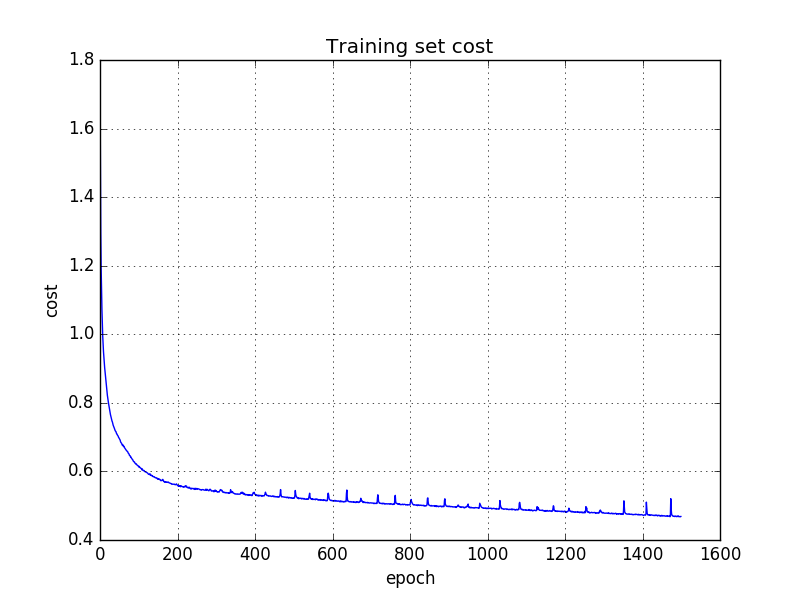

In [2]:
from IPython.display import Image
Image('images/nn_c.png')

Confusion matrix: training set

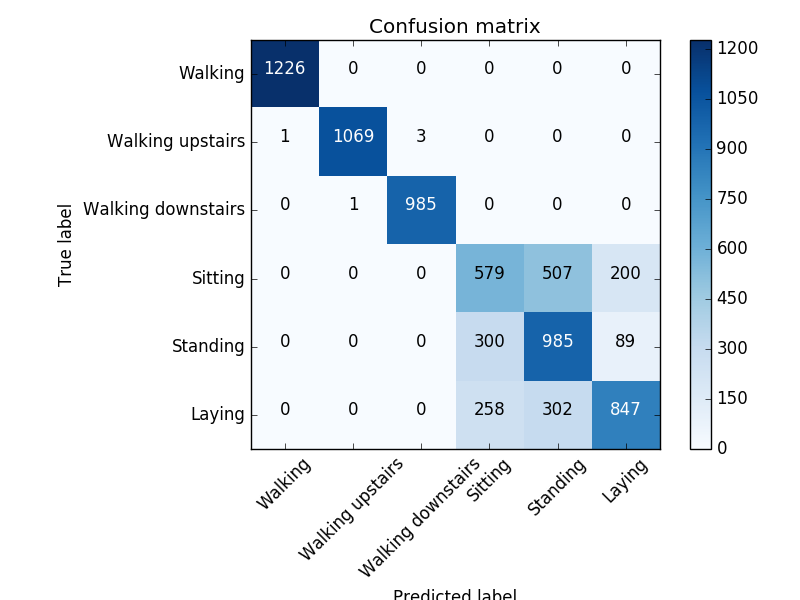

In [3]:
Image('images/nn_train.png')

Confusion matrix: test set

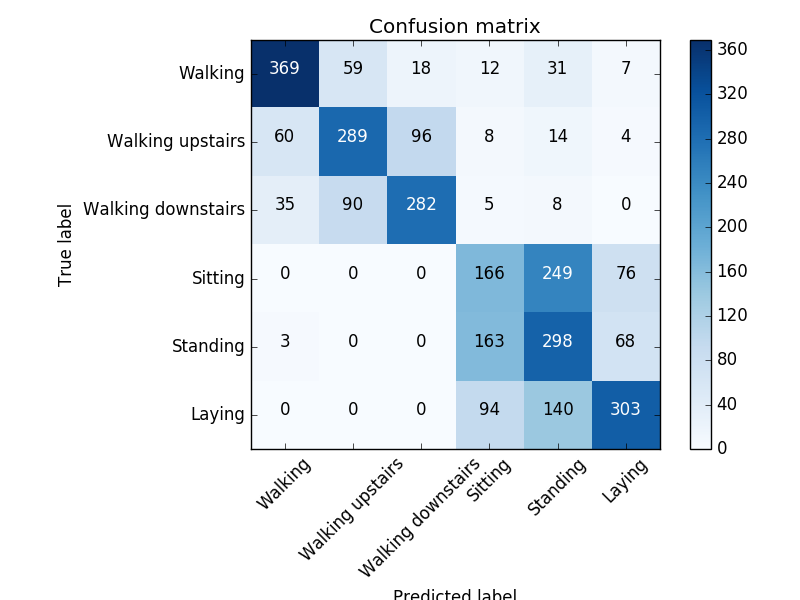

In [4]:
Image('images/nn_test.png')

### Comments

Using the raw accelerometer data to feed a neural network does not seem to be the most efficient way to get good predictions. 
The training phase shows that the neural networks fails to differentiate correctly "sitting", "standing" and "laying" samples while it achieves good results on the first three labels. We can understand this problem by looking at the plots in the introduction of this repository: x axis raw signals are not very different for "sitting", "standing" and "laying" (you can try to plot more of them to check by yourself).
Finally the test set results are quite bad especially for the three last labels.
In the case of HAR dataset using raw data does not achieve good results. The notebook using feature data ([here](https://github.com/jeandeducla/ML-Time-Series/blob/master/Neural_Network-Accelerometer-Features.ipynb)) achieves better results since we can build features vectors with information on the three axis of the accelerometer while here we are only using one.